# STEP 1. 작업환경 구성하기

In [2]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

# STEP 2. 데이터셋 구성하기

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# CIFAR-10 데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
print(train_x.shape)  

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)


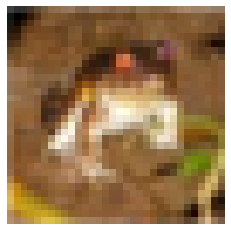

In [4]:
# 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
train_x = (train_x - 127.5) / 127.5

# 로드한 학습 데이터 시각화로 확인
plt.imshow((train_x[0] * 127.5 + 127.5).astype(np.uint8))
plt.axis('off')
plt.savefig('first_image.png')  # Jupyter에서 시각화 확인용 저장

#### train_x에 저장된 CIFAR-10의 훈련 데이터 중 첫 번째 이미지(train_x[0])
#### CIFAR-10: 실제 세계의 다양한 객체(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)를 촬영한 사진들로 구성된 데이터셋
#### 10개 class로 라벨링

In [5]:
# tf.data.Dataset으로 미니배치 데이터셋 구성
BATCH_SIZE = 256
BUFFER_SIZE = 50000
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 3. 생성자 모델 구현하기

In [6]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

generator = make_generator_model()

In [7]:
# 랜덤 노이즈로 이미지 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

(1, 32, 32, 3)


# STEP 4. 판별자 모델 구현하기

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()

In [9]:
# 생성된 랜덤 이미지 판별 결과 확인
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00126778]], shape=(1, 1), dtype=float32)


# STEP 5. 손실함수와 최적화 함수 구현하기

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    return (real_accuracy + fake_accuracy) / 2.0

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# STEP 6. 훈련과정 상세 기능 구현하기

In [11]:
import os

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, discriminator_accuracy(real_output, fake_output)

def generate_and_save_images(model, epoch, test_input, save_dir):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.close(fig)

def draw_train_history(history, epoch, save_dir):
    plt.figure()
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'loss_at_epoch_{epoch:04d}.png'))
    plt.close()
    plt.figure()
    plt.plot(history['disc_accuracy'], label='Discriminator Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'accuracy_at_epoch_{epoch:04d}.png'))
    plt.close()

checkpoint_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기

In [12]:
EPOCHS = 50
save_every = 5
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
history = {'gen_loss': [], 'disc_loss': [], 'disc_accuracy': []}
generated_samples_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')
training_history_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_history')

def train(dataset, epochs, save_every):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        disc_accuracy_list = []
        for image_batch in dataset:
            g_loss, d_loss, d_acc = train_step(image_batch)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)
            disc_accuracy_list.append(d_acc)
        history['gen_loss'].append(np.mean(gen_loss_list))
        history['disc_loss'].append(np.mean(disc_loss_list))
        history['disc_accuracy'].append(np.mean(disc_accuracy_list))
        generate_and_save_images(generator, epoch + 1, seed, generated_samples_dir)
        draw_train_history(history, epoch + 1, training_history_dir)
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch+1}, Gen Loss: {history["gen_loss"][-1]}, Disc Loss: {history["disc_loss"][-1]}, Disc Accuracy: {history["disc_accuracy"][-1]}')

train(train_dataset, EPOCHS, save_every)

Epoch 1, Gen Loss: 1.0107176303863525, Disc Loss: 1.1683666706085205, Disc Accuracy: 0.6778618693351746
Epoch 2, Gen Loss: 1.5356796979904175, Disc Loss: 0.8416519165039062, Disc Accuracy: 0.7926797866821289
Epoch 3, Gen Loss: 1.9475682973861694, Disc Loss: 0.6130300164222717, Disc Accuracy: 0.8791275024414062
Epoch 4, Gen Loss: 1.5260064601898193, Disc Loss: 0.8646842837333679, Disc Accuracy: 0.8164222240447998
Epoch 5, Gen Loss: 1.3886260986328125, Disc Loss: 0.8368220329284668, Disc Accuracy: 0.8216239213943481
Epoch 6, Gen Loss: 1.502485990524292, Disc Loss: 0.8326258063316345, Disc Accuracy: 0.8204798698425293
Epoch 7, Gen Loss: 1.5289069414138794, Disc Loss: 0.7763000726699829, Disc Accuracy: 0.846000075340271
Epoch 8, Gen Loss: 1.5534882545471191, Disc Loss: 0.8251951336860657, Disc Accuracy: 0.8266202807426453
Epoch 9, Gen Loss: 1.6284692287445068, Disc Loss: 0.8371127247810364, Disc Accuracy: 0.8209164142608643
Epoch 10, Gen Loss: 1.7050368785858154, Disc Loss: 0.8220881223678

In [13]:
# 학습 과정 시각화 (GIF 생성)
import imageio

def make_gif(images_dir, gif_name):
    images = []
    for epoch in range(1, EPOCHS + 1):
        filename = os.path.join(images_dir, f'image_at_epoch_{epoch:04d}.png')
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_name, images, fps=5)

make_gif(generated_samples_dir, 'cifar10_dcgan.gif')

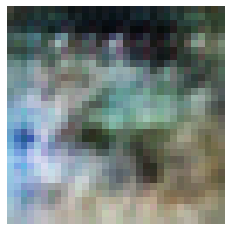

In [14]:
# 학습된 모델 로드 및 이미지 생성
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)
generator = checkpoint.generator
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5 + 127.5).astype(np.uint8)
plt.imshow(np_generated[0])
plt.axis('off')
plt.savefig('generated_image.png')

#### 생성자 모델(generator)이 랜덤 노이즈(noise = tf.random.normal([1, 100]))를 입력으로 받아 생성

## 학습이 불안정한 결과

### 생성자 손실 (Gen Loss)
Epoch 1: 0.969 → Epoch 50: 1.442
중간에 Epoch 4에서 1.943까지 증가한 후 점차 감소하다가 다시 약간 증가하는 추세
전체적으로 손실이 안정화되지 않고 변동이 큼

### 판별자 손실 (Disc Loss)
Epoch 1: 1.106 → Epoch 50: 1.073
Epoch 3에서 0.605까지 내려갔다가 다시 증가하며 1.0 근처에서 변동이 있음
판별자도 손실이 일정하게 수렴하지 않고 오르내림

### 판별자 정확도 (Disc Accuracy)
Epoch 1: 0.711 → Epoch 50: 0.735
Epoch 3에서 0.882로 최고점을 찍은 후 점차 감소하며 0.7~0.8 사이를 맴돌고 있음

## Step8. (optional) GAN 훈련 과정 개선하기

### 시도해볼 수 있는 것들

### 1. 학습률 조정
현재 생성자와 판별자의 학습률이 서로 균형을 맞추지 못했을 가능성이 있음
ex) 생성자의 학습률을 조금 낮추거나(예: 0.0001), 판별자의 학습률을 살짝 높여서(예: 0.0004) 둘의 균형을 조정 가능

### 2. 모델 구조 변경
생성자나 판별자의 네트워크를 조금 더 깊게 만들거나(레이어 추가), 필터 수를 늘려서 모델의 표현력을 키워볼 수 있음
ex) 생성자에 컨볼루션 레이어를 하나 더 추가하거나 판별자의 필터를 64개에서 128개로 늘리는 식으로 실험 가능

### 3. 정규화 기법 사용
배치 정규화(Batch Normalization)나 드롭아웃(Dropout)을 추가해서 모델이 과적합되거나 불안정해지는 걸 줄일 수 있음
ex) 판별자에 드롭아웃(예: 0.3)을 넣으면 과도하게 강해지는 걸 막을 수 있음

### 4. 학습 데이터 증강
ex) 이미지 회전, 뒤집기, 자르기 같은 증강 기법을 써서 모델의 일반화 성능을 높일 수 있음

### 5. 더 많은 에포크 학습
현재: 50 에포크까지 학습
ex) 100 에포크 정도 더 학습하면서 손실이 안정화되는지 관찰

# idea: 모델의 구조를 개선해보자!

## WGAN(Wasserstein GAN)
기존 GAN의 학습 불안정성 문제를 해결하기 위해 제안된 모델 (봐서스테인 GAN)

### <핵심 idea>

#### 손실 함수로 Wasserstein 거리(Wasserstein Distance)를 사용
#### 판별자(Critic)가 특정 조건을 만족하도록 Gradient Penalty라는 규제항 추가
#### 결과적으로 판별자가 더 착하고 친절함 (+생성자보다 학습 더 많이 함)

### 기존 구조와의 공통점
Generator와 Discriminator 모두 기본적으로 GAN/DCGAN에서 쓰이는 합성곱(Conv)·전치합성곱(Transposed Conv) 계층을 그대로 사용

배치정규화(BatchNorm)나 활성화 함수(ReLU, Leaky ReLU, tanh)도 거의 동일하게 적용

### 기존 구조와의 차별점
목적 함수를 JS divergence 기반의 minimax 게임에서 Wasserstein 거리(EM distance) 근사로 변경

Discriminator를 “판별자(discriminator)”가 아니라 “점수 함수(critic)”로 부르며, 출력층에 sigmoid 대신 선형(linear) 활성화를 사용

Lipschitz 연속성을 보장하기 위해 weight clipping(WGAN) 또는 gradient penalty(WGAN-GP)를 추가해 학습 안정성을 크게 높임

## 참고내용

### <Wasserstein 거리>
두 분포(실제 데이터 분포와 생성 데이터 분포) 사이의 차이를 측정하는 값

### 직관적인 이해
- 기존 GAN: "진짜냐 가짜냐"를 맞추는 방식
- WGAN은 "얼마나 다른가"를 측정하는 방식 
- 한 분포를 다른 분포로 바꾸는 데 필요한 최소한의 "노동량" = 지구 이동 거리(Earth Mover's Distance)

### <GAN의 문제점>
1. 생성된 데이터 분포와 실제 데이터 분포 간의 차이를 측정하기 위해 사용하는 KL 발산과 JS 발산은, 두 분포가 겹치지 않을 때 그 거리가 무한대가 되고 불연속상태가 됨
2. 학습 초기에 생성자가 형편없는 데이터를 생성하면 판별자에게 유의미한 기울기 정보를 전달하기 어렵게 만듦 (Vanishing Gradient 문제)

### <WGAN의 장점>

##### 1. 학습 안정성 향상
Wasserstein 거리의 유의미한 기울기: 실제 데이터와 생성 데이터의 분포가 겹치지 않아도 의미 있는 기울기 정보를 제공합니다.
균형 잡힌 학습 메커니즘: 비평가와 생성자 간 학습 균형이 자연스럽게 유지됩니다.
비평가 최적화 허용: 비평가를 생성자보다 더 많이 학습(일반적으로 5:1 비율)시켜도 생성자 학습이 방해받지 않습니다.

##### 2. 모드 붕괴 문제 완화
다양한 출력 생성: 생성자가 데이터 분포의 다양한 모드를 포착하도록 유도합니다.
전체 분포 매칭: 생성자가 데이터 분포의 일부가 아닌 전체를 모델링합니다.

##### 3. 수렴 문제 해결
명확한 진행 지표: Wasserstein 거리 값이 감소하면 실제로 생성 품질이 향상됨을 보장합니다.
예측 가능한 학습 과정: 학습이 더 안정적이고 예측 가능한 패턴으로 진행됩니다.

##### 4. 기울기 소실 방지
지속적인 기울기 제공: 판별자가 완벽하게 구분할 수 있는 상황에서도 유용한 기울기 정보가 유지됩니다.
1-Lipschitz 제약: 기울기 크기가 적절하게 제한되어 너무 작거나 크지 않도록 보장합니다.

### <WGAN의 Gradient Penalty 도입 배경>
1. Wasserstein 거리를 손실 함수로 사용하기 위해서는 판별자(Critic)가 1-Lipschitz continuous이어야 함. (함수의 기울기의 크기가 특정 값(1)을 넘지 않도록 제한하는 조건)
2. 원래는 1-Lipschitz continuous를 강제하기 위해, 판별자의 가중치를 특정 범위 내로 자르는 클리핑(weight clipping)하는 방법을 사용
3. Critic이 데이터를 잘 표현하지 못할 수 있고, 학습이 불안정해질 수 있음

### Gradient Penalty의 도입 원리
1. WGAN-GP(Wasserstein GAN with Gradient Penalty)에서는 가중치 클리핑 대신 Gradient Penalty라는 규제항을 손실 함수에 추가
이 페널티는 판별자(Critic)의 입력에 대한 기울기의 노름(크기)이 1에서 너무 벗어나지 않도록 학습
2. 1-Lipschitz continuous를 "부드럽게" 강제하는 방식
가중치 클리핑의 단점을 보완하여 더욱 안정적인 학습을 가능하게 하고, 때로는 더 높은 품질의 이미지를 생성하는 데 도움을 줌
- Weight Clipping = "가중치를 자르라"고 강제로 막는 방식
- Gradient Penalty = "기울기가 1에서 너무 멀어지면 손실을 조금 더 줘서 조정해"라는 부드러운 방법

### 1-Lipschitz Continuity
- 함수의 변화율(기울기)이 1 이하로 제한된다는 수학적 조건 = Critic이 너무 예민하지 않도록 만드는 규칙
- Wasserstein 거리를 계산하려면 Critic이 이 조건을 만족해야 함

### Critic 함수 = 데이터를 입력받아 실수값을 출력하는 함수 f
- 모든 입력 x와 y에 대해, |f(x) - f(y)| ≤ |x - y|가 성립해야 함
- 사진 두 장이 살짝 다를 때 Critic이 "완전 다르다!"라고 과민 반응하면 안 되고, 차이만큼만 반응해야 함(이진 분류 0or1 대신 실수값 출력해 얼마나 다른지 정보 제공)

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers

# 하이퍼파라미터 설정
BATCH_SIZE = 256
NOISE_DIM = 100
EPOCHS = 50
generated_samples_dir = './generated_samples'

# Optimizer 설정 (WGAN-GP 권장 값)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)

# CIFAR-10 데이터셋 로드 및 전처리
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(BATCH_SIZE, drop_remainder=True)

# 생성자 모델 정의
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# 판별자 모델 정의
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Gradient Penalty 계산 함수
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0, dtype=tf.float32)
    real_images = tf.cast(real_images, tf.float32)
    fake_images = tf.cast(fake_images, tf.float32)
    interpolated = alpha * real_images + (1.0 - alpha) * fake_images
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grads_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((grads_l2 - 1.0) ** 2)
    return gp

# WGAN-GP 손실 함수 정의
def wgan_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def wgan_discriminator_loss(real_output, fake_output, gp, gp_weight=10.0):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + gp_weight * gp

# 훈련 스텝 함수
@tf.function
def train_step_wgan(real_images, generator, discriminator):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    for _ in range(5):
        with tf.GradientTape() as disc_tape:
            fake_images = generator(noise, training=True)
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(fake_images, training=True)
            gp = gradient_penalty(discriminator, real_images, fake_images)
            disc_loss = wgan_discriminator_loss(real_output, fake_output, gp)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = wgan_generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_loss, disc_loss

# 전체 훈련 함수
def train_wgan(dataset, epochs, generator, discriminator, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    fixed_seed = tf.random.normal([16, NOISE_DIM])
    for epoch in range(epochs):
        gen_losses, disc_losses = [], []
        for real_batch in dataset:
            g_loss, d_loss = train_step_wgan(real_batch, generator, discriminator)
            gen_losses.append(g_loss)
            disc_losses.append(d_loss)
        print(f"Epoch {epoch+1}/{epochs}, Generator Loss: {np.mean(gen_losses):.4f}, Discriminator Loss: {np.mean(disc_losses):.4f}")
        if (epoch + 1) % 5 == 0:
            preds = generator(fixed_seed, training=False)
            fig = plt.figure(figsize=(4, 4))
            for i in range(16):
                plt.subplot(4, 4, i+1)
                img = (preds[i] * 127.5 + 127.5).numpy().astype(np.uint8)
                plt.imshow(img)
                plt.axis('off')
            plt.savefig(os.path.join(save_dir, f'wgan_gp_epoch_{epoch+1:04d}.png'))
            plt.close(fig)

In [30]:
# 모델 생성 및 훈련 실행
generator = build_generator()
discriminator = build_discriminator()

In [31]:
train_wgan(train_dataset, EPOCHS, generator, discriminator, generated_samples_dir)

Epoch 1/50, Generator Loss: 0.7088, Discriminator Loss: -5.3329
Epoch 2/50, Generator Loss: -6.6273, Discriminator Loss: -2.3689
Epoch 3/50, Generator Loss: -13.7246, Discriminator Loss: -2.8219
Epoch 4/50, Generator Loss: -15.1065, Discriminator Loss: -2.4801
Epoch 5/50, Generator Loss: -17.3154, Discriminator Loss: -2.3338
Epoch 6/50, Generator Loss: -17.8223, Discriminator Loss: -2.5033
Epoch 7/50, Generator Loss: -16.7239, Discriminator Loss: -2.4331
Epoch 8/50, Generator Loss: -14.4188, Discriminator Loss: -2.2781
Epoch 9/50, Generator Loss: -13.7149, Discriminator Loss: -2.1394
Epoch 10/50, Generator Loss: -13.1438, Discriminator Loss: -2.0313
Epoch 11/50, Generator Loss: -13.2062, Discriminator Loss: -1.9437
Epoch 12/50, Generator Loss: -12.9782, Discriminator Loss: -1.8302
Epoch 13/50, Generator Loss: -12.1825, Discriminator Loss: -1.7616
Epoch 14/50, Generator Loss: -11.1826, Discriminator Loss: -1.6938
Epoch 15/50, Generator Loss: -10.8455, Discriminator Loss: -1.6824
Epoch 1

## WGAN 결과 분석

### 생성자 손실 (Generator Loss)

#### 초기에는 양수 값(0.7088)을 보이다가 빠르게 음수로 전환되어 그 절댓값이 점차 증가하는 경향 
#### 절댓값이 커지는 것 = 생성자가 판별자를 더 잘 속이게 된다는 간접적 신호
#### 기존 GAN은 1 근처에서 변동하며 수렴하지 않았던 것과 비교하면, WGAN의 생성자 손실은 안정적인 변화를 보임 (초기에 큰 폭으로 감소(-17.8)한 후 점차 안정화(-8~-9 범위))

### 판별자 손실 (Discriminator Loss)

#### 전반적으로 음수 값을 유지하며, 학습이 진행됨에 따라 0에 가까워지는 경향
#### 판별자가 실제와 가짜 이미지를 잘 구별하지 못하게 되는 이상적인 상황을 의미
#### 기존 GAN에서는 판별자 손실이 1 근처에서 불안정하게 오르내리던 것에 비해, WGAN의 판별자 손실은 더 안정적으로 감소하는 경향

## 시각화
사실 원본 이미지가 개구리 같은데, GAN이나 WGAN이나 둘 다 그렇게 시각화 결과가 좋아 보이진 않음

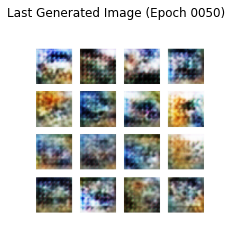

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

generated_samples_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')

def visualize_last_generated_image(images_dir):
    """
    주어진 디렉토리에서 가장 마지막에 저장된 생성 이미지를 시각화합니다.

    Args:
        images_dir (str): 이미지 파일들이 저장된 디렉토리 경로.
    """
    filenames = sorted([f for f in os.listdir(images_dir) if f.startswith('image_at_epoch_') and f.endswith('.png')])
    if not filenames:
        print(f"'{images_dir}' 디렉토리에 생성된 이미지 파일이 없습니다.")
        return

    last_filename = filenames[-1]
    last_epoch = int(last_filename.split('_')[-1].split('.')[0])
    last_image_path = os.path.join(images_dir, last_filename)
    img = mpimg.imread(last_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Last Generated Image (Epoch {last_epoch:04d})")
    plt.show()

visualize_last_generated_image(generated_samples_dir)

GIF 애니메이션 'cifar10_dcgan_existing.gif'이(가) 생성되었습니다.


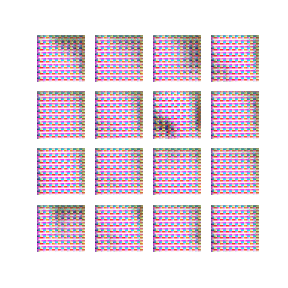

In [37]:
import imageio
import os

generated_samples_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')
gif_filename = 'cifar10_dcgan_existing.gif'

def make_gif_existing(images_dir, gif_name, duration=0.5):
    """
    주어진 디렉토리의 기존 이미지 파일들을 사용하여 GIF 애니메이션을 생성합니다.

    Args:
        images_dir (str): 이미지 파일들이 저장된 디렉토리 경로.
        gif_name (str): 생성될 GIF 파일 이름.
        duration (float): 각 프레임 간의 지속 시간 (초).
    """
    images = []
    filenames = sorted([f for f in os.listdir(images_dir) if f.startswith('image_at_epoch_') and f.endswith('.png')])
    if not filenames:
        print(f"'{images_dir}' 디렉토리에 생성된 이미지 파일이 없습니다.")
        return

    for filename in filenames:
        filepath = os.path.join(images_dir, filename)
        images.append(imageio.imread(filepath))
    imageio.mimsave(gif_name, images, duration=duration)
    print(f"GIF 애니메이션 '{gif_name}'이(가) 생성되었습니다.")

# GIF 생성 실행
make_gif_existing(generated_samples_dir, gif_filename)

# Jupyter Notebook에서 GIF를 표시하는 방법 (선택 사항, pillow 필요)
from IPython.display import Image
Image(filename=gif_filename)